# Analysis, Visualization and Recommendation

![](https://media.contentapi.ea.com/content/www-easports/en_US/fifa/ultimate-team/news/2017/fut-online-match-modes/_jcr_content/imageShare.img.jpg)

In this kernel I've designed to illustrate what insights could be driven using FIFA 19 Game dataset. The kernel is divided into following sections:
* Analysis
* Feature Engineering
* Recommendation


## 1. Ingestion

### Import Libraries

In [1]:
# Install Plotly Express
!pip install plotly.express

     |████████████████████████████████| 11.5MB 4.3MB/s 
  Found existing installation: plotly 3.10.0
    Uninstalling plotly-3.10.0:
      Successfully uninstalled plotly-3.10.0


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import os
import re

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("Path:", os.path.join(dirname, filename))


Path: /kaggle/input/data.csv


In [3]:
datafr = pd.read_csv("../input/data.csv", error_bad_lines=False)

### Display the structure of the dataset

In [4]:
display(datafr.head(10))

Unnamed: 0      ID       ...       GKReflexes  Release Clause
0           0  158023       ...              8.0         €226.5M
1           1   20801       ...             11.0         €127.1M
2           2  190871       ...             11.0         €228.1M
3           3  193080       ...             94.0         €138.6M
4           4  192985       ...             13.0         €196.4M
5           5  183277       ...              8.0         €172.1M
6           6  177003       ...              9.0         €137.4M
7           7  176580       ...             37.0           €164M
8           8  155862       ...             11.0         €104.6M
9           9  200389       ...             89.0         €144.5M

[10 rows x 89 columns]

### Identifying the shape of the dataset

In [5]:
# Dimension of the datatset
print("Dimension of the dataset is: ",datafr.shape)

Dimension of the dataset is:  (18207, 89)


### Missing values for each attribute

In [6]:
# Check the missing values in the column
missing_data = datafr.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index(drop=False)
missing_data = missing_data.rename(columns={"index": "Columns", 0: "Value"})
missing_data['Proportion'] = (missing_data['Value']/len(datafr))*100

In [7]:
sample = missing_data[missing_data['Proportion']>10]
fig = px.pie(sample, names='Columns', values='Proportion',
             color_discrete_sequence=px.colors.sequential.Plasma_r,
             title='Proportion of missing values greater than 10%')
fig.update_traces(textposition='inside', textinfo='label')
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

In [8]:
missing_gk = datafr[datafr['Position']=='GK'].isnull().sum().sort_values(ascending=False)
# Check the missing values in the column
missing_gk = missing_gk.reset_index(drop=False)
missing_gk = missing_gk.rename(columns={"index": "Columns", 0: "Value"})
missing_gk['Proportion'] = (missing_gk['Value']/len(datafr))*100

In [9]:
sample = missing_gk[missing_gk['Proportion']>10]
fig = px.pie(sample, names='Columns', values='Proportion',
             color_discrete_sequence=px.colors.sequential.Magma_r,
             title='Proportion of missing values greater than 10% for Position GK')
fig.update_traces(textposition='inside', textinfo='label')
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

Drop Unnecessary columns that have large missing values or won't be used in analysis

In [10]:
# Drop Unnecessary columns
datafr = datafr.drop(['Unnamed: 0', 'ID', 'Photo', 'Flag', 'Club Logo', 'Body Type', 'Real Face', 'Loaned From', 'Joined'], axis=1)
datafr = datafr.fillna(0)

### Data Preprocessing & Feautre Engineering

1: Height, Weight and BMI

In [11]:
# Convert Weight from String(lbs) to Float(kg)
ls = []
for i in range(len(datafr)):
    ls.append(re.sub('lbs', '', str(datafr['Weight'][i])))
datafr['Weight'] = [float(number) / 2.205 for number in ls]

# Convert Height from String(feet) to Float(cm)
ls = []
for i in range(len(datafr)):
    ls.append(re.sub('(\')', '.', str(datafr['Height'][i])))
datafr['Height'] = [float(number) * 30 for number in ls]

**Compute BMI**

In [12]:
datafr['bmi'] = datafr['Weight'] / (datafr['Height']/100)**2

2: Value

In [13]:
ls = []
ls_value = []
for i in range(len(datafr)):
    ls.append(re.sub('€', '', str(datafr['Value'][i])))
for i in ls:
    if re.search("K", i):
        x = re.sub("K","",i)
        ls_value.append(float(x)*1000)
    elif re.search("M", i):
        y = re.sub("M","",i)
        ls_value.append(float(y)*1000000)
    else:
        ls_value.append(0)
datafr['Value'] = ls_value

## 2. Visualization

### A. Relationship b/w Overall and Age

In [14]:
fig = go.Figure()
sample = datafr.sort_values(by='Overall')
fig = go.Figure(data=go.Scatter(
    x = sample['Overall'],
    y = sample['Age'],
    mode='markers',
    marker=dict(
        size=16,
        color=sample['International Reputation'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= sample['Name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by International Reputation) year 2019 - Overall vs Age',
                  xaxis_title='Overall',
                  yaxis_title='Age',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

**This relationship is not clear, as player's jersey number is associated more with size of club and their importance of role or position. Thus we won't be using Jersey Number as our feature.**

### B. Relationship b/w Player Value & Jersey Number

In [15]:
fig = go.Figure()
sample = datafr.sort_values(by='Value')
fig = go.Figure(data=go.Scatter(
    x = sample['Jersey Number'],
    y = sample['Value'],
    mode='markers',
    marker=dict(
        size=16,
        color=sample['Age'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= sample['Name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by Age) year 2019 - Jersey Number vs Value',
                  xaxis_title='Jersey Number',
                  yaxis_title='Value',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

Players with Jersey Number between 1-40 are highly valuable compared to player wearing jersey number over 40

### C: Relationship b/w Overall & Value

In [16]:
fig = go.Figure()
sample = datafr.sort_values(by='Overall')
fig = go.Figure(data=go.Scatter(
    x = sample['Overall'],
    y = sample['Value'],
    mode='markers',
    marker=dict(
        size=16,
        color=sample['Age'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= sample['Name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by Age) year 2019 - Overall vs Value',
                  xaxis_title='Overall',
                  yaxis_title='Value',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

### D. Ratio of players by Nationality

In [17]:
fig = px.pie(datafr, names='Nationality',
             color_discrete_sequence=px.colors.sequential.Plasma_r,
             title='Proportion of Players based on Nationality')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

In [18]:
datafr['Nationality'].value_counts()[:10]

England        1662
Germany        1198
Spain          1072
Argentina       937
France          914
Brazil          827
Italy           702
Colombia        618
Japan           478
Netherlands     453
Name: Nationality, dtype: int64

**In our given dataset, more than 50% of players come from popular countries like England, Germany, Spain, Argentina and France. This could be explained by the popularity and sizes of domestic leagues within these nations.**

In [19]:
smart_buy = datafr[(datafr['Contract Valid Until']=='2019') & (datafr['Overall']>=75)]
young_buy = smart_buy[smart_buy['Potential']>smart_buy['Overall']]
experience_buy = smart_buy[smart_buy['Age']>30]

### E. Youth prospects with high potential growth

In [20]:
fig = go.Figure()
sample = young_buy.sort_values(by='Overall')
fig = go.Figure(data=go.Scatter(
    x = sample['Age'],
    y = sample['Potential'],
    mode='markers',
    marker=dict(
        size=16,
        color=sample['Value'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= sample['Name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by Age) year 2019 - Age vs Potential',
                  xaxis_title='Age',
                  yaxis_title='Potential',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

**From the above scatter plot, we get to know that there are few players that a club manager could pursue since their contract is running only till 2019 so either club managers could  negotiate less or directly negotiate with player in January transfer window. We might target those players represented by Purples dots in top left quadrant as their current Overall Rating and future Potential rating is high.**

### F. Ratio of youth prospects by Position

#### Create a dataset for young prospects

In [21]:
youth_special = datafr[(datafr['Overall']>75) & (datafr['Potential'] - datafr['Overall']>=10)].sort_values(by='Overall',ascending=False)
cols = ['Name','Club','Age','Overall','Potential','Position','Value']
youth_special[cols]

Name                Club     ...      Position       Value
229         G. Donnarumma               Milan     ...            GK  29000000.0
415              H. Aouar  Olympique Lyonnais     ...            LM  23500000.0
734             A. Lafont          Fiorentina     ...            GK  14000000.0
735   T. Alexander-Arnold           Liverpool     ...            RB  14000000.0
744           D. Calabria               Milan     ...            RB  14500000.0
755              J. Gomez           Liverpool     ...            CB  14500000.0
1143      Vinícius Júnior         Real Madrid     ...            LW  17500000.0
1172           N. Barella            Cagliari     ...           RCM  15500000.0
1149         R. Bentancur            Juventus     ...           RCM  15500000.0
1156           A. Diawara              Napoli     ...            CM  14000000.0
1110         D. Upamecano          RB Leipzig     ...           LCB  13000000.0
1070           P. Cutrone               Milan     ...            RS  16000000.0
1029             C. Ünder                Roma     ...            LM  14500000.0
1004            J. Sancho   Borussia Dortmund     ...            RM  14500000.0
1231               Wendel         Sporting CP     ...           RCM  12500000.0
1296          H. Onyekuru      Galatasaray SK     ...            ST  12500000.0
1312     Gedson Fernandes          SL Benfica     ...           RCM  12000000.0
1343              I. Sarr    Stade Rennais FC     ...            RM  13500000.0
1422            B. Embolo       FC Schalke 04     ...            ST  12500000.0
1450            Marc Roca        RCD Espanyol     ...           CDM  11500000.0
1479           K. Tierney              Celtic     ...            LB  11000000.0
1522             A. Ćorić                Roma     ...           CAM  14000000.0
1544             A. Lunin          CD Leganés     ...            GK  10500000.0
1564             S. Berge            KRC Genk     ...           RCM  11500000.0

[24 rows x 7 columns]

Text(0.5, 1.0, 'Distribution of young prospects by Overall')

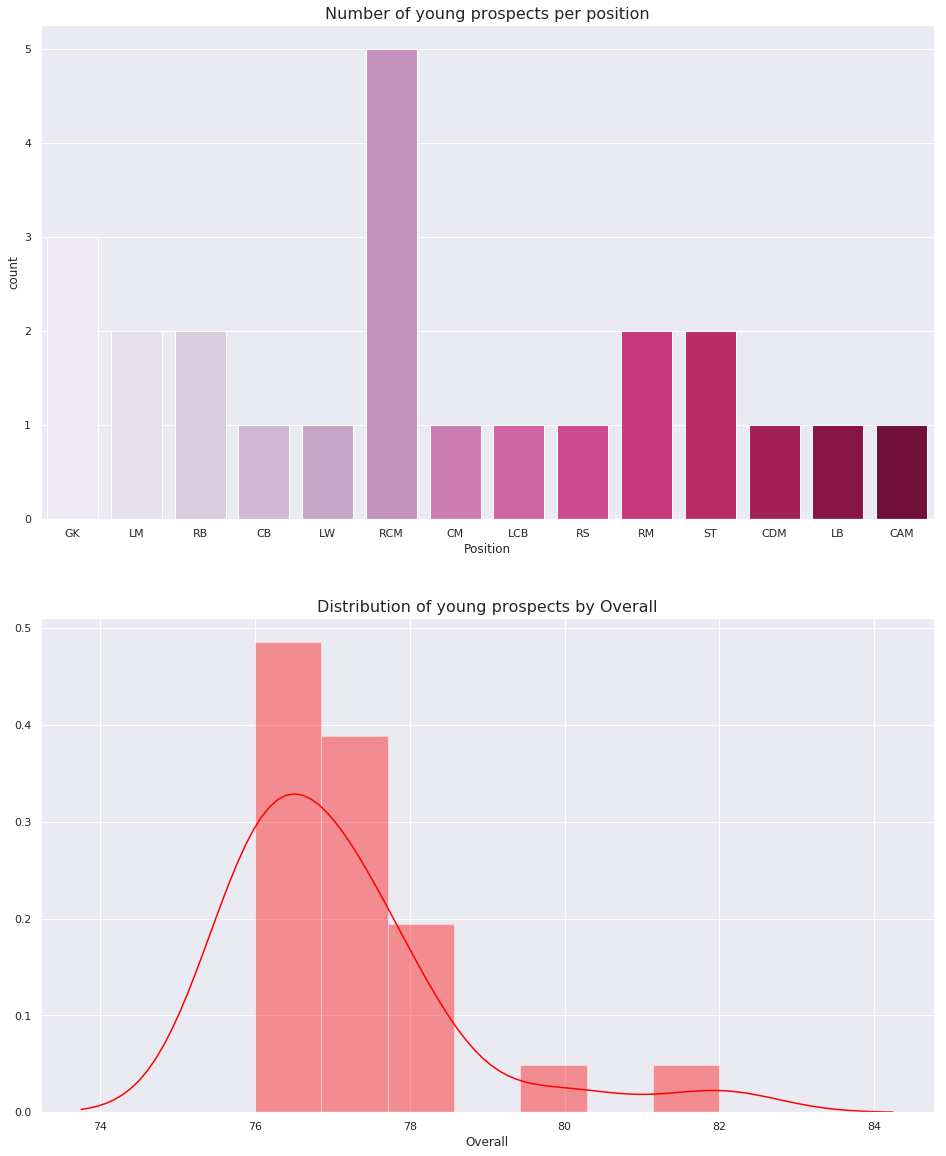

In [22]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(nrows=2, figsize=(16, 20))
sns.countplot(youth_special['Position'], palette="PuRd", ax=axs[0])
axs[0].set_title('Number of young prospects per position', fontsize=16)
sns.distplot(youth_special['Overall'],color="Red", ax=axs[1])
axs[1].set_title('Distribution of young prospects by Overall', fontsize=16)

In [23]:
youth_special['Position'].unique()

array(['GK', 'LM', 'RB', 'CB', 'LW', 'RCM', 'CM', 'LCB', 'RS', 'RM', 'ST',
       'CDM', 'LB', 'CAM'], dtype=object)

In [24]:
fig = px.pie(youth_special, names='Position',
             color_discrete_sequence=px.colors.sequential.Plasma_r,
             title='Proportion of Young Players based on Position')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

## 3. Predictions

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [26]:
datafr = datafr.drop(['Contract Valid Until','Release Clause','LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',  'RW','LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM','CDM', 'RDM', 'RWB', 'LB', 'LCB','CB', 'RCB', 'RB'],axis=1)

In [27]:
datafr.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Jersey Number',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'bmi'],
      dtype='object')

In [28]:
datafr.iloc[:, 16:]

Height     Weight    ...      GKReflexes        bmi
0       171.0  72.108844    ...             8.0  24.660184
1       186.0  82.993197    ...            11.0  23.989247
2       177.0  68.027211    ...            11.0  21.713815
3       192.0  76.190476    ...            94.0  20.667989
4       153.3  69.841270    ...            13.0  29.718564
5       174.0  73.922902    ...             8.0  24.416337
6       174.0  66.213152    ...             9.0  21.869848
7       180.0  86.167800    ...            37.0  26.595000
8       180.0  82.086168    ...            11.0  25.335237
9       186.0  87.074830    ...            89.0  25.169046
10      180.0  79.818594    ...            10.0  24.635369
11      180.0  76.190476    ...            10.0  23.515579
12      186.0  78.004535    ...            15.0  22.547270
13      174.0  67.120181    ...            12.0  22.169435
14      168.0  72.108844    ...            10.0  25.548768
15      153.0  74.829932    ...             8.0  31.966309
16      186.0  88.888889    ...            11.0  25.693401
17      177.0  73.015873    ...            14.0  23.306161
18      186.0  84.807256    ...            90.0  24.513602
19      198.0  96.145125    ...            88.0  24.524315
20      186.0  76.190476    ...            13.0  22.022915
21      183.0  77.097506    ...            10.0  23.021740
22      192.0  92.063492    ...            87.0  24.973821
23      174.0  69.841270    ...            14.0  23.068196
24      186.0  84.807256    ...             3.0  24.513602
25      153.0  73.015873    ...             6.0  31.191368
26      177.0  71.201814    ...            14.0  22.727126
27      183.0  83.900227    ...            12.0  25.053070
28      153.3  78.004535    ...            14.0  33.192162
29      162.0  58.956916    ...            10.0  22.464912
...       ...        ...    ...             ...        ...
18177   153.0  73.922902    ...            12.0  31.578838
18178   180.0  79.818594    ...            51.0  24.635369
18179   186.0  73.922902    ...             8.0  21.367471
18180   183.0  78.004535    ...            45.0  23.292584
18181   153.3  60.770975    ...            10.0  25.859010
18182   153.0  74.829932    ...             6.0  31.966309
18183   186.0  86.167800    ...            46.0  24.906868
18184   183.0  81.179138    ...            15.0  24.240538
18185   153.3  72.108844    ...             8.0  30.683452
18186   153.0  78.911565    ...             8.0  33.709926
18187   153.0  73.015873    ...            12.0  31.191368
18188   153.0  67.120181    ...            10.0  28.672810
18189   153.0  74.829932    ...             8.0  31.966309
18190   177.0  79.818594    ...             8.0  25.477543
18191   153.3  76.190476    ...            12.0  32.420251
18192   183.0  74.829932    ...            13.0  22.344630
18193   174.0  66.213152    ...            11.0  21.869848
18194   189.0  84.807256    ...            44.0  23.741568
18195   174.0  63.945578    ...            13.0  21.120881
18196   171.0  66.213152    ...             8.0  22.643942
18197   153.0  63.945578    ...            15.0  27.316664
18198   153.3  69.841270    ...            48.0  29.718564
18199   168.0  68.027211    ...            15.0  24.102612
18200   177.0  71.201814    ...            11.0  22.727126
18201   183.0  76.190476    ...            13.0  22.750896
18202   177.0  60.770975    ...             9.0  19.397675
18203   189.0  77.097506    ...            12.0  21.583244
18204   174.0  67.120181    ...            13.0  22.169435
18205   153.0  69.841270    ...             9.0  29.835221
18206   153.0  79.818594    ...             9.0  34.097396

[18207 rows x 37 columns]

### Selecting columns to find similarity among players

In [29]:
attributes = datafr.iloc[:, 16:]
attributes['Skill Moves'] = datafr['Skill Moves']
attributes['Age'] = datafr['Age']
workrate = datafr['Work Rate'].str.get_dummies(sep='/ ')
attributes = pd.concat([attributes, workrate], axis=1)
df = attributes
attributes = attributes.dropna()
df['Name'] = datafr['Name']
df['Position'] = datafr['Position']
df = df.dropna()
print(attributes.columns)

Index(['Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'bmi', 'Skill Moves', 'Age', '0', 'High', 'Low', 'Medium'],
      dtype='object')


### Displaying our attribute set

In [30]:
attributes.head()

Height     Weight  Crossing  Finishing   ...    0  High  Low  Medium
0   171.0  72.108844      84.0       95.0   ...    0     0    0       1
1   186.0  82.993197      84.0       94.0   ...    0     1    1       0
2   177.0  68.027211      79.0       87.0   ...    0     1    0       1
3   192.0  76.190476      17.0       13.0   ...    0     0    0       1
4   153.3  69.841270      93.0       82.0   ...    0     1    0       0

[5 rows x 43 columns]

### Correlation Matrix based on attribute set

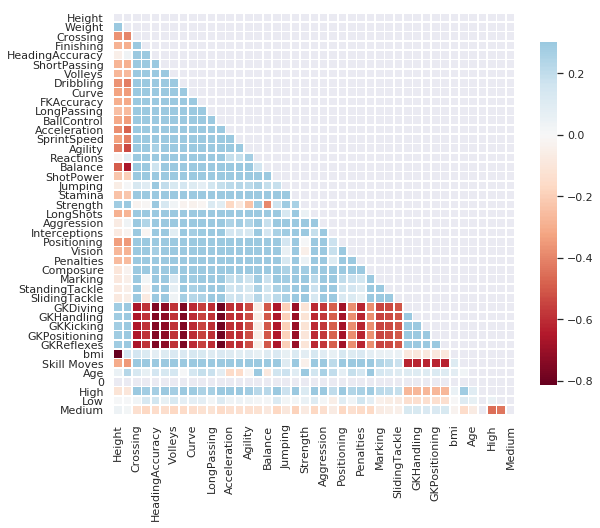

In [31]:
plt.figure(figsize=(9,9))

# Compute the correlation matrix
corr = attributes.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="RdBu", vmax=.3, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .7})

**From the above correlation chart, we can see a lot of Goalkeepers attributes have a negative correlation with the attributes possessed by a Forward, Midfielder and Defender.**

### Standardize the dataset

In [32]:
scaled = StandardScaler()
X = scaled.fit_transform(attributes)

### Create recommendations using NearestNeighbors ML

In [33]:
recommendations = NearestNeighbors(n_neighbors=5,algorithm='kd_tree')
recommendations.fit(X)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Get Similar Players index

In [34]:
player_index = recommendations.kneighbors(X)[1]

In [35]:
player_index

array([[    0,     5,     2,    23,    15],
       [    1,   124,   170,   713,    17],
       [    2,     5,    65,    94,    26],
       ...,
       [18156, 18015, 17994, 17860, 17770],
       [18157, 17868, 18068, 17890, 17435],
       [18158, 18051, 17936, 18009, 17714]])

### Define a recommend function to display results

In [36]:
def get_index(x):
    return df[df['Name']==x].index.tolist()[0]

def recommend_similar(player):
    print("These are 4 players similar to {} : ".format(player))
    index=  get_index(player)
    for i in player_index[index][1:]:
        print("Name: {0}\nPosition: {1}\n".format(df.iloc[i]['Name'],df.iloc[i]['Position']))

**Test 1 : Eden Hazard**

In [37]:
recommend_similar('E. Hazard')

These are 4 players similar to E. Hazard : 
Name: Neymar Jr
Position: LW

Name: Douglas Costa
Position: LM

Name: M. Salah
Position: RM

Name: N. Fekir
Position: CAM



**Test 2 : Mohamed Salah**

In [38]:
recommend_similar(player='M. Salah')

These are 4 players similar to M. Salah : 
Name: S. Mané
Position: LM

Name: Alex Teixeira
Position: LS

Name: L. Sané
Position: LW

Name: Giuliano
Position: CAM



**Test 3 : Manuel Neuer**

In [39]:
recommend_similar('M. Neuer')

These are 4 players similar to M. Neuer : 
Name: K. Schmeichel
Position: GK

Name: De Gea
Position: GK

Name: J. Pickford
Position: GK

Name: S. Romero
Position: GK



**Test 4: Joe Gomez (Young Prospect)**

In [40]:
recommend_similar('J. Gomez')

These are 4 players similar to J. Gomez : 
Name: N. Elvedi
Position: RCB

Name: M. Holgate
Position: CB

Name: C. Mavinga
Position: LCB

Name: L. Klostermann
Position: RB

